# Differential Expression and Pathway analysis
The goal of this notebook is to take the processed feature counts and experimental design tables and use GSEA, ROntoTools, and QuaternaryProd to generate and compare pathway analyses. This notebook runs code in R using the DESeq2 differential expression package.

1. input full featureCount tables into DESeq2
2. ROntoTools
3. GSEA
4. QuaternaryProd with STRING database

## Preparation
1. install R packages (see R install document)


## Instructions
Before running this notebook, format the feature count data with the featureCountprocessing-generic notebook. The notebooks are separated because the processing notebook runs Python code, not R. Once the processed featureCounts and experimental design table have been created:

1. Run the first cell to import the necessary libraries and define the functions used to process the data.
2. 

In [17]:
#import libraries
library("DESeq2")

#define functions for DESeq2 object creation and heatmap creation
#based on Griffith Lab tutorial here: https://genviz.org/module-04-expression/0004/02/01/DifferentialExpression/

#input and process sample data (experiment design)
input_sample_data <- function(filepath, print_debug=FALSE){
    sampleData <- read.delim(filepath)
    #save copy of sampleData
    #sampleData_v2 <- sampleData
    
    rownames(sampleData) <- sampleData$SampleID.Lab
    #make data type = factor for Cell Line and Time Point (both otherwise treated as continuous variables since both are numbers)
    sampleData$Cell.Line <- factor(sampleData$Cell.Line)
    sampleData$Time.Point <- factor(sampleData$Time.Point)
    if(print_debug == TRUE){
        print(head(sampleData))
        }
    return(sampleData)
}

#Input and process raw gene counts (Feature Counts)
input_raw_counts <- function(filepath, sampleData, print_debug=FALSE){
    rawCounts <- read.delim(filepath)
    #print(head(rawCounts))
    
    geneID <- rawCounts$Geneid
    sampleIndex <- grepl("ES\\d+", colnames(rawCounts))
    rawCounts <- as.matrix(rawCounts[,sampleIndex])
    rownames(rawCounts) <- geneID
     if(print_debug == TRUE){
        print(head(rawCounts))
    }
    rawCounts <- rawCounts[,unique(rownames(sampleData))]
    if(print_debug == TRUE){
        print(head(rawCounts))
    }
    cat("Test that dimensions of rawCounts and sampleData match:", all(colnames(rawCounts) == rownames(sampleData)), "\n")
    return(rawCounts)
}


In [21]:
#H358 input rawCounts (featureCounts) and sample data (experimental design)
sampleData_H358 <- input_sample_data("20210209_experiment_design_H358.tsv")
rawCounts_H358 <- input_raw_counts("20210209_featureCount_H358.tsv", sampleData_H358)
#make DESeq2DataSet object, specifying CRISPR status as a blocking factor and Time point as the comparison variable
#choosing blocking factor and comparison variable is required, and if there are no divisions in the category chosen an error will occur "model matrix is not full rank"
dds_H358 <- DESeqDataSetFromMatrix(countData=rawCounts_H358, colData=sampleData_H358, design= ~ CRISPR + Time.Point)

Test that dimensions of rawCounts and sampleData match: TRUE 


In [24]:
head(sampleData_H358)

,X,SampleID.Lab,Cell.Line,Inhibition.Status,CRISPR,MRTX,BI,SHP2i,Time.Point,Population
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
ES58NTXX01,0,ES58NTXX01,58,NTXX,NT,False,False,False,0,A
ES58NTXX02,1,ES58NTXX02,58,NTXX,NT,False,False,False,0,A
ES58NTXX03,2,ES58NTXX03,58,NTXX,NT,False,False,False,0,B
ES58NTXX04,3,ES58NTXX04,58,NTXX,NT,False,False,False,0,B
ES58S1XX01,4,ES58S1XX01,58,S1XX,S1,False,False,False,0,A
ES58S1XX02,5,ES58S1XX02,58,S1XX,S1,False,False,False,0,A


In [20]:
#filter for genes with at least 5 counts across all samples to reduce dimensions
print(dim(dds_H358))
print(dim(deseq2Data[rowSums(counts(deseq2Data)) > 5, ]))
dds_H358 <- dds[rowSums(counts(dds)) > 5, ]

[1] 63677    59

[1] 34696    59

In [22]:
#load BiocParallel library and register number of cores to use (based on CPU) for parallel processing to increase speed
#if used set parallel = TRUE for DEseq() and results()
library(BiocParallel)
register(MulticoreParam(4))

In [23]:
#perform DESeq on dataset object to estimate size factors, dispersion, and find negative bionomial GLM fitting and Wald statistic
#Takes several minutes
dds_H358_DESeq <- DESeq(dds_H358, parallel=TRUE)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 4 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [26]:
dds_H358_results <- results(dds_H358_DESeq, contrast=c("CRISPR", "S1", "NT"))
summary(dds_H358_results)


out of 42301 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1777, 4.2%
LFC < 0 (down)     : 1538, 3.6%
outliers [1]       : 2, 0.0047%
low counts [2]     : 25544, 60%
(mean count < 12)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



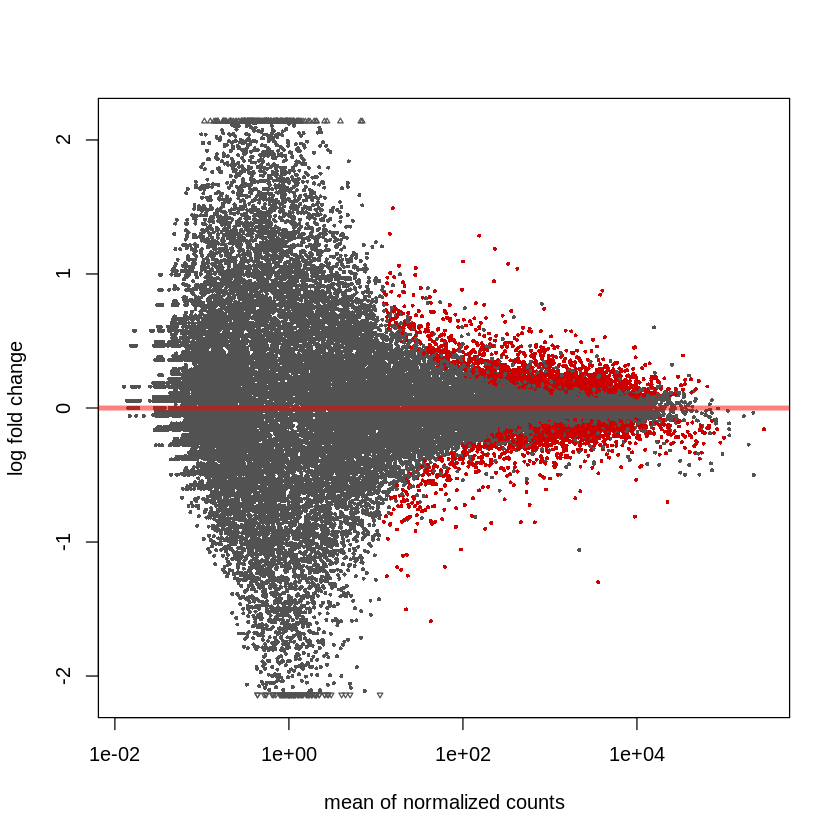

In [27]:
plotMA(dds_H358_results)


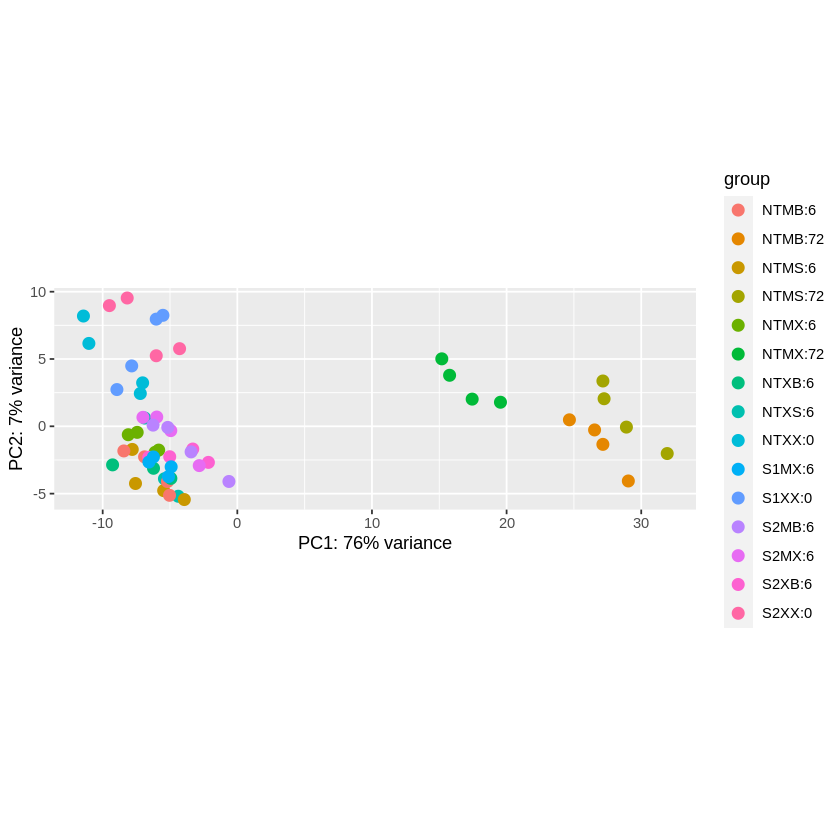

In [30]:
#PCA and sample distances
vsd <- vst(dds_H358_DESeq, blind=FALSE)
plotPCA(vsd, intgroup=c("Inhibition.Status", "Time.Point"))

In [34]:
plt <- plotPCA(vsd, intgroup=c("CRISPR", "Population"))

In [38]:
#print to file
png("Results/H358_PCA_cell_pop.png")
print(plt)
dev.off()

png 
  2

In [39]:
plt <- plotPCA(vsd, intgroup=c("Inhibition.Status", "Time.Point"))
png("Results/H358_PCA_inhib-timept.png")
print(plt)
dev.off()

png 
  2